# Imports

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta
import geopandas
import matplotlib.pyplot as plt
# import matplotlib.animation
#from matplotlib.animation import FuncAnimation
import mapclassify
import matplotlib.patches as mpatches
import celluloid #pip install celluloid
from IPython.display import HTML # to display video in notebook (requires conda install ffmpeg)


import sys
sys.path.insert(0, "../tools")

from plotting import add_scalebar, add_north_arrow

# Prepare community shapes

Origin shapefile:

https://ac.ngi.be/remoteclient-open/ngi-standard-open/Vectordata/AdminVector/AdminVector_L08_shp.zip


In [2]:
communities_geom = geopandas.read_file('../data/NGI_AdminVector_L08_shp/AD_2_Municipality.shp')
NGI_url = 'zip+https://ac.ngi.be/remoteclient-open/ngi-standard-open/Vectordata/AdminVector/AdminVector_L08_shp.zip'
communities_geom.NISCode = communities_geom.NISCode.astype(int)
communities_geom = communities_geom[['NISCode','geometry']]

In [3]:
# read inhabitants
url_inhabitants = 'https://statbel.fgov.be/sites/default/files/files/documents/bevolking/5.1%20Structuur%20van%20de%20bevolking/Bevolking_per_gemeente.xlsx'
inhabitants = pd.read_excel(url_inhabitants, skipfooter=4, skiprows=1).dropna(how='all', axis=0)
inhabitants['NIS code'] = inhabitants['NIS code'].astype(int)


In [ ]:
## Uncomment to save locally:
#inhabitants.to_csv('../data/inhabitants.csv')
## Uncomment to read locally:
#inhabitants = pd.read_csv('../data/inhabitants.csv')

In [4]:
communities = pd.merge(communities_geom, inhabitants, left_on = 'NISCode', right_on = 'NIS code').drop(columns=['NIS code'])
communities = communities.rename(columns={'Totaal':'inhabitants'})

In [ ]:
#communities.plot('inhabitants')

# Read sciensano data

In [5]:
## To update data until yesterday
datelist = pd.date_range(start = pd.to_datetime('2020-03-31'), end = datetime.today() - timedelta(days=1)).strftime("%Y%m%d")
#datelist = pd.date_range(start = pd.to_datetime('2020-03-31'), end = pd.to_datetime('2020-05-11')).strftime("%Y%m%d")

In [6]:
# To remain some time on the last frame
datelist = list(datelist) + [datelist[-1]]*20

In [7]:
## Safe data locally (to be safe)
# for date in datelist:
#     url = 'https://epistat.sciensano.be/Data/'+ date +'/COVID19BE_CASES_MUNI_CUM_'+ date +'.csv'
#     cases_day_x = pd.read_csv(url, encoding = "ISO-8859-1", skipfooter=1).dropna(axis=0, how='all').copy()
#     cases_day_x.to_csv('../data/cumulative_cases_per_community/'+'COVID19BE_CASES_MUNI_CUM_'+ date +'.csv')

In [8]:
def prepare_case_data(date, read_local = False):
    if read_local == True:
        cases_day_x = pd.read_csv('../data/cumulative_cases_per_community/'+'COVID19BE_CASES_MUNI_CUM_'+ date +'.csv')
    else:
        url = 'https://epistat.sciensano.be/Data/'+ date +'/COVID19BE_CASES_MUNI_CUM_'+ date +'.csv'
        cases_day_x = pd.read_csv(url, encoding = "ISO-8859-1", skipfooter=1, engine='python').dropna(axis=0, how='all').copy()
        # engine = 'python' to avoid skipfooter warning
    cases_day_x.NIS5 = cases_day_x.NIS5.astype(int)
    cases_day_x = cases_day_x[['NIS5','TX_DESCR_NL','CASES']].copy()
    # Assume <5 cases to be 3 cases
    cases_day_x.loc[cases_day_x.CASES.str.find('<')!=-1, 'CASES'] = '3'
    cases_day_x.CASES = cases_day_x.CASES.astype(int)
    return cases_day_x

In [9]:
def prepare_plot_data(date):
    cases_day_x = prepare_case_data(date)
    cases_with_geo = pd.merge(communities[['NISCode', 'geometry', 'inhabitants']] , cases_day_x[['NIS5','CASES']], left_on = 'NISCode', right_on = 'NIS5')
    cases_with_geo['cases_per_100000'] = cases_with_geo.CASES/cases_with_geo.inhabitants*100000
    return cases_with_geo

# Make map

Origin Ugent logo: 

https://styleguide.ugent.be/files/uploads/logo_UGent_EN.zip

In [21]:
logo_ugent = plt.imread('../data/logo_UGent_EN_RGB_2400_color.png')
#plt.imshow(logo_ugent)

In [11]:
cases_with_geo = prepare_plot_data(datelist[0])

**fisher_jenks scheme**: seeks to reduce the variance within classes and maximize the variance between classes (This is done by seeking to minimize each class's average deviation from the class mean, while maximizing each class's deviation from the means of the other groups.)

http://darribas.org/gds15/content/labs/lab_04.html

In [12]:
last = prepare_plot_data(datelist[-2])
classi = mapclassify.FisherJenks(last['cases_per_100000'], k=7)
FJ_bins = classi.bins.round(-1).astype(int)
FJ_bins = [0]+list(FJ_bins)
FJ_bins[-1] = 100000

In [13]:
# Check boundaries
#pd.cut(last['cases_per_100000'], bins= FJ_bins).value_counts()

In [14]:
# Prepare legend labels
lower_lims = [str(x) for x in FJ_bins[:-1]]
lower_lims[-1] = '> '+lower_lims[-1]
upper_lims = [' - ' + str(x) for x in FJ_bins[1:]]
upper_lims[-1] = ''
labels = [x+y for x,y in zip(lower_lims, upper_lims)]

In [15]:
# union of belgium (to draw contours)
Belgium = last.unary_union

(508329.4487999987, 808831.0523999992, 510030.5161999996, 755173.3173999998)

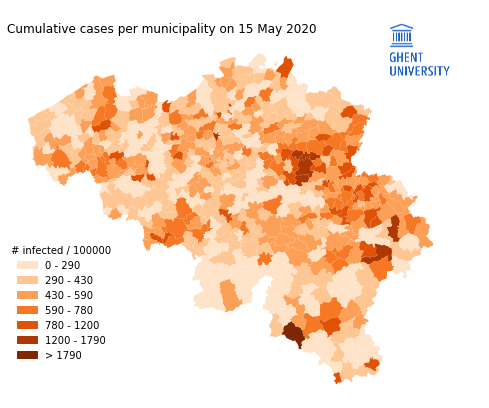

In [56]:
fig, ax = plt.subplots(figsize=(8,8))

last.plot(column=pd.cut(last['cases_per_100000'], bins= FJ_bins), cmap='Oranges', 
          legend=True, ax=ax, vmin=-1, vmax=6)
leg = ax.get_legend()
patches = [mpatches.Patch(color=p.get_markerfacecolor()) for p in leg.legendHandles]
ax.legend(patches, labels, loc = (0, 0.1), frameon=False, bbox_transform=ax.transAxes, title='# infected / 100000')
ax.text(0, 1.01, 'Cumulative cases per municipality on ' + pd.to_datetime(datelist[-2]).strftime('%d %B %Y'),
        transform=ax.transAxes, fontsize=12)
newax = fig.add_axes([0.75, 0.67, 0.2, 0.2], anchor='NE', zorder=1)
newax.imshow(logo_ugent, interpolation = 'bilinear')
newax.axis('off')
ax.axis('off')
#height = logo_ugent.size[1]
#fig.figimage(logo_ugent, 0, 0.5, resize=True)#, fig.bbox.ymax - height


In [62]:
def cleaned_plot(date, ax):
    temp = prepare_plot_data(date)
    temp.plot(column=pd.cut(temp['cases_per_100000'], bins= FJ_bins), cmap='Oranges', 
              legend=False, ax=ax, vmin=-1, vmax=6)
    ax.legend(patches, labels, loc = (0, 0.1), frameon=False, bbox_transform=ax.transAxes, title='# infected / 100000')

    geopandas.GeoSeries([Belgium.boundary]).plot(ax=ax, color='k', lw=0.1)

    add_north_arrow(ax, (0.9, 0.1))
    add_scalebar(ax, (512000, 510030), length=50000, fac=' 50 km')
    
    #ax.set_title('Cumulative cases per municipality on ' + pd.to_datetime(date).strftime('%d %B %Y'))
    ax.text(0, 1.01, 'Cumulative cases per municipality on ' + pd.to_datetime(date).strftime('%d %B %Y'), 
            transform=ax.transAxes, fontsize=12)
    
    newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
    newax.imshow(logo_ugent, interpolation = 'bilinear')
    newax.axis('off')
    
    return ax

<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_ax

<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance w

<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance w

<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance w

<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  newax = fig.add_axes([0.75, 0.75, 0.2, 0.2], anchor='NE', zorder=1)
<ipython-input-65-07a55ffa1875>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.get_figure().tight_layout()
<ipython-input-62-58262e037f0f>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance w

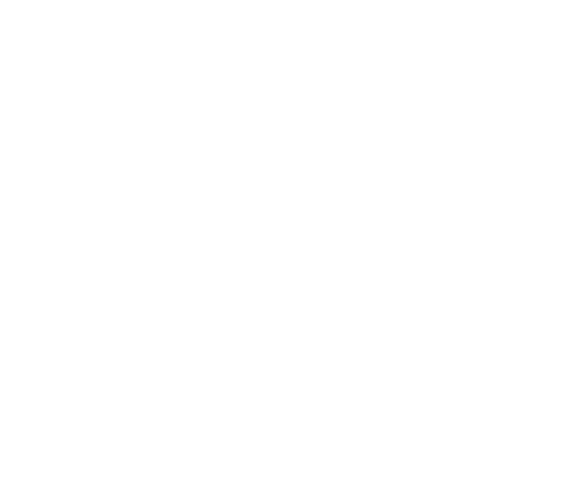

In [65]:
# takes long! about 2s per frame
fig, ax = plt.subplots(figsize=(8,8))
camera = celluloid.Camera(fig)
ax = cleaned_plot(datelist[0], ax)
extent = ax.axis()
camera.snap()
for date in datelist:
    cleaned_plot(date, ax)
    ax.axis(extent)
    ax.set_axis_off()
    ax.get_figure().tight_layout()
    camera.snap()
fig.tight_layout()
animation = camera.animate(interval=250)
#anim = matplotlib.animation.FuncAnimation(fig, anim_func, frames=datelist, fargs=(ax, ), interval=250)
HTML(animation.to_html5_video())

In [66]:
animation.save("../results/map_cases_dynamic_new.gif", writer='imagemagick')#, savefig_kwargs=dict(bbox='tight'))